In [3]:
import os
import torch
import math
import torch
import pandas as pd
import numpy as np
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from torch import optim
from tqdm import tqdm
import logging
from torch.utils.tensorboard import SummaryWriter

In [4]:
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")
def setup_logging(run_name):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("models", run_name), exist_ok=True)
    os.makedirs(os.path.join("results", run_name), exist_ok=True)

# Data Preprocessing

In [5]:
# Fred's encoder code
class DescreteEncoder:
    def __init__(self, duration: int = 1440, step_size: int = 10):
        self.duration = duration
        self.step_size = step_size
        self.steps = duration // step_size
        self.index_to_acts = {}
        self.acts_to_index = {}

    def encode(self, data: pd.DataFrame):
        # Create mappings from activity to index and vice versa
        self.index_to_acts = {i: a for i, a in enumerate(data.act.unique())}
        self.acts_to_index = {a: i for i, a in self.index_to_acts.items()}
        
        # Create a new DataFrame for encoded data
        encoded_data = data.copy()
        encoded_data['act'] = encoded_data['act'].map(self.acts_to_index)
        return encoded_data
    
    def decode(self, encoded_image_grid) -> pd.DataFrame:
        if isinstance(encoded_image_grid, torch.Tensor):
            encoded_image_grid = encoded_image_grid.numpy()
        
        decoded = []
        for pid in range(encoded_image_grid.shape[0]):
            sequence = encoded_image_grid[pid]
            current_act = None
            act_start = None
            
            for time_step, act_index in enumerate(sequence):
                # If the activity changes or it's the end of the day, record the activity
                if act_index != current_act and current_act is not None:
                    act_end = time_step * self.step_size
                    decoded.append({
                        "pid": pid,
                        "act": self.index_to_acts[current_act],
                        "start": act_start,
                        "end": act_end
                    })
                    act_start = time_step * self.step_size
                # If the activity changes, update the current activity
                if act_index != current_act:
                    current_act = act_index
                    act_start = time_step * self.step_size
            
            # Add the last activity of the day if the day ended with an activity
            if current_act is not None and act_start is not None:
                decoded.append({
                    "pid": pid,
                    "act": self.index_to_acts[current_act],
                    "start": act_start,
                    "end": self.duration
                })

        return pd.DataFrame(decoded, columns=["pid", "act", "start", "end"])

In [6]:
# Load data and encode it
data = pd.read_csv('./data/nts_population.csv')
encoder = DescreteEncoder()
encoded_data = encoder.encode(data)

# Function to convert encoded data into an image grid
def create_image_grid(encoded_data, encoder):
    # Map pid to sequential indices starting from 0
    pid_to_index = {pid: index for index, pid in enumerate(encoded_data['pid'].unique())}
    
    num_people = len(pid_to_index)
    time_steps = encoder.steps
    grid = np.zeros((num_people, time_steps))
    
    for _, row in encoded_data.iterrows():
        pid_index = pid_to_index[row['pid']]
        act_index = row['act']
        start_step = row['start'] // encoder.step_size
        end_step = row['end'] // encoder.step_size
        grid[pid_index, start_step:end_step] = act_index
    
    return grid

image_grid = create_image_grid(encoded_data, encoder)
tensor_image_grid = torch.tensor(image_grid)
torch.save(tensor_image_grid, './data/image_grid.pt')

In [7]:
# Inspect mappings
print("Index to Activities Mapping:")
print(encoder.index_to_acts)
print("\nActivities to Index Mapping:")
print(encoder.acts_to_index)

# Calculate vocabulary size
vocab_size = len(encoder.index_to_acts)
print("\nVocabulary Size:", vocab_size)

# Compare vocabulary size to expected size
expected_vocab_size = 8  # Assuming 'ntoken' is the expected vocabulary size
if vocab_size != expected_vocab_size:
    print(f"Warning: Vocabulary size ({vocab_size}) does not match expected size ({expected_vocab_size})")
else:
    print("Vocabulary size matches expected size")

Index to Activities Mapping:
{0: 'home', 1: 'shop', 2: 'work', 3: 'escort', 4: 'other', 5: 'education', 6: 'visit', 7: 'medical'}

Activities to Index Mapping:
{'home': 0, 'shop': 1, 'work': 2, 'escort': 3, 'other': 4, 'education': 5, 'visit': 6, 'medical': 7}

Vocabulary Size: 8
Vocabulary size matches expected size


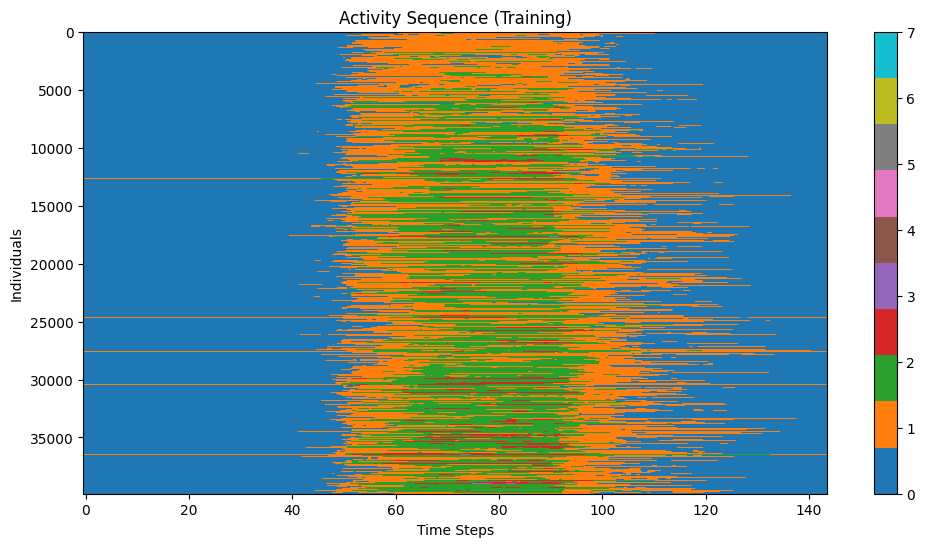

In [8]:
def plot_image_grid(image_grid, title = 'Activity Sequence (Training)' ):    
    plt.figure(figsize=(12, 6))
    plt.imshow(image_grid, aspect='auto', cmap="tab10")
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Individuals')
    plt.show()
plot_image_grid(image_grid)

In [9]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

class ActivityDataset(TensorDataset):
    def __init__(self, sequences, context_size=2):
        self.data = []
        for sequence in sequences:
            for i in range(context_size, len(sequence) - context_size):
                context = [sequence[i + j] for j in range(-context_size, context_size + 1) if j != 0]
                target = sequence[i]
                self.data.append((torch.tensor(context), torch.tensor(target)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        inputs = inputs.to(device)  # Ensure inputs are on the correct device
        embedded = self.embeddings(inputs).mean(dim=1)
        out = self.linear(embedded)
        return out

def train_model(dataset, model, optimizer, epochs=10, device="cuda"):
    model.train()
    loss_function = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        total_loss = 0
        for context, target in DataLoader(dataset, batch_size=128, shuffle=True):
            context, target = context.to(device), target.to(device)  # Ensure data is on the correct device
            model.zero_grad()
            log_probs = model(context)
            loss = loss_function(log_probs, target.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch}, Loss: {total_loss / len(dataset)}')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = ActivityDataset(tensor_image_grid.long(), context_size=2)
CBOW = CBOWModel(vocab_size=8, embedding_dim=8).to(device)
optimizer = optim.Adam(CBOW.parameters(), lr=0.001)

# Train the model
train_model(dataset, CBOW, optimizer, epochs=1)

C:\Users\rakin\AppData\Local\Temp\ipykernel_23508\3552875137.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data.append((torch.tensor(context), torch.tensor(target)))


Epoch 0, Loss: 0.0004000319050128798


In [10]:
embedding_weights = CBOW.embeddings.weight.data

activities_to_idx = {
    'home': 0, 'shop': 1, 'work': 2, 'escort': 3, 'other': 4, 'education': 5, 'visit': 6, 'medical': 7
}

# Print the vector for each activity
for activity, idx in activities_to_idx.items():
    vector = embedding_weights[idx]
    print(f"Vector for {activity}: {vector}")

Vector for home: tensor([-2.0019, -2.9903,  1.5478,  0.4809, -1.2578,  0.8253,  1.5039, -2.4581],
       device='cuda:0')
Vector for shop: tensor([-3.2494, -2.0635, -1.8030, -1.9400,  1.4341, -1.2564,  2.0023,  0.1527],
       device='cuda:0')
Vector for work: tensor([-1.2420,  2.3758, -0.8819,  2.1232,  1.0681,  3.2160, -0.9884,  0.1084],
       device='cuda:0')
Vector for escort: tensor([ 2.9467,  1.8691,  2.1500, -2.0285,  0.1511,  1.6714,  1.8362, -1.1433],
       device='cuda:0')
Vector for other: tensor([-1.4613,  0.0979,  2.8228,  0.1661,  2.2857, -1.1059, -2.4978, -2.5236],
       device='cuda:0')
Vector for education: tensor([-0.9923,  2.4019, -2.6187,  1.9025, -3.6946, -1.3961,  1.9821, -0.9573],
       device='cuda:0')
Vector for visit: tensor([ 0.2300, -0.9520, -2.9439, -2.1263, -2.7519,  0.8220, -2.9277, -1.4311],
       device='cuda:0')
Vector for medical: tensor([ 2.6404, -3.3613,  0.6325, -1.0807, -2.0718, -1.3347,  2.2921,  3.1731],
       device='cuda:0')


In [11]:
tensor_image_grid = tensor_image_grid.to(device)
tensor_image_grid = tensor_image_grid.long()

# Apply embeddings
embedded_sequences = CBOW.embeddings(tensor_image_grid)


dataset = TensorDataset(embedded_sequences)

batch_size = 64  
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  


for embedded_batch in dataloader:
    print(embedded_batch[0].shape)  #([batch_size, 144, embedding_dim])
    break


torch.Size([64, 144, 8])


# Diffusion

In [12]:
class Diffusion:
    def __init__(self, noise_steps=500, beta_start=0.0001, beta_end=0.015, sequence_length=144, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.sequence_length = sequence_length
        self.device = device

        self.beta = self.schedule_noise().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def schedule_noise(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def noise_embeddings(self, embeddings, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat[t])[:, None, None]

        epsilon = torch.randn_like(embeddings)

        noisy_embeddings = sqrt_alpha_hat * embeddings + sqrt_one_minus_alpha_hat * epsilon

        # Debug: Check for NaNs
        if torch.isnan(noisy_embeddings).any():
            print("NaNs detected in noisy_embeddings")
            print("sqrt_alpha_hat:", sqrt_alpha_hat)
            print("sqrt_one_minus_alpha_hat:", sqrt_one_minus_alpha_hat)
            print("epsilon:", epsilon)

        return noisy_embeddings.float(), epsilon.float()

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, embedding_dim):
        logging.info(f"Sampling {n} new sequences...")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, self.sequence_length, embedding_dim)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                
                alpha = self.alpha[t][:, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None]
                beta = self.beta[t][:, None, None]

                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)

                x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * predicted_noise) + torch.sqrt(beta) * noise

        model.train()
        return x

![Diffusion Sampling Algorithm](sampling.png)


In [13]:
from models.transformer import TransformerWithPositionalEncoding

def setup_logging(run_name):
    logging.basicConfig(level=logging.INFO)

def train(model, diffusion, device):
    run_name = "first_run"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    learning_rate = 0.004
    epochs = 1

    setup_logging(run_name)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    mse = nn.MSELoss() 
    logger = SummaryWriter(os.path.join("runs", run_name))

    for epoch in range(epochs):
        logging.info(f"Starting epoch {epoch}")
        epoch_loss = 0.0
        for batch_idx, (x,) in enumerate(tqdm(dataloader)):
            embedded_x = x.to(device) 

            optimizer.zero_grad()  
            timesteps = torch.randint(0, diffusion.noise_steps, (embedded_x.size(0),), device=device)
            embedded_x = embedded_x.float()
            noisy_x, noise = diffusion.noise_embeddings(embedded_x, timesteps)
            predicted_x = model(noisy_x, timesteps)

            loss = mse(noise, predicted_x)
            loss.backward(retain_graph=True)
            optimizer.step()  
            epoch_loss += loss.item()

            # Log training loss to TensorBoard every 10 batches
            if batch_idx % 10 == 0:
                logger.add_scalar("Loss/train", loss.item(), epoch * len(dataloader) + batch_idx)

        avg_epoch_loss = epoch_loss / len(dataloader)
        logging.info(f"Epoch {epoch} Average Loss: {avg_epoch_loss}")
        logger.add_scalar("Loss/epoch_avg_train", avg_epoch_loss, epoch)

    logger.close()

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TransformerWithPositionalEncoding(feature_size=8, num_layers=4, max_time_steps=501).to(device)
diffusion = Diffusion(noise_steps=500, beta_start=0.0001, beta_end=0.015, sequence_length=144, device="cuda")

train(model, diffusion, device=device)

09:51:39 - INFO: Starting epoch 0
100%|██████████| 623/623 [02:30<00:00,  4.15it/s]
09:54:09 - INFO: Epoch 0 Average Loss: 0.5620853063287169


In [14]:
save_path = os.path.join("saved_models", f"model.pth")
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Ensure directory exists
torch.save(model.state_dict(), save_path)
logging.info(f"Model saved to {save_path}")

09:54:09 - INFO: Model saved to saved_models\model.pth


In [15]:
def map_embeddings_to_activities(embedded_sequences, CBOW):

    embeddings = CBOW.embeddings.weight.data
    
    # Normalize embeddings to unit vectors
    embeddings = F.normalize(embeddings, p=2, dim=1)

    
    embedded_sequences = F.normalize(embedded_sequences, p=2, dim=-1)

    # Calculate dot products (shape: [n * sequence_length, NUM_ACTIVITIES])
    n, sequence_length, embedding_dim = embedded_sequences.size()
    embedded_sequences_flat = embedded_sequences.view(-1, embedding_dim)  # Reshape for matmul
    dot_products = torch.matmul(embedded_sequences_flat, embeddings.T)
    
    # The resulting indices are the activities (shape: [n * sequence_length])
    _, activities = torch.max(dot_products, dim=1)

    # Reshape back to original sequence format ([n, sequence_length])
    activities = activities.view(n, sequence_length)
    
    return activities


In [45]:
# After generating new sequences using the diffusion model
generated_sequences = diffusion.sample(model = model, n=360, embedding_dim=8)

# Map the generated sequences back to discrete activities
discrete_activities = map_embeddings_to_activities(generated_sequences, CBOW)


12:00:56 - INFO: Sampling 360 new sequences...
499it [01:30,  5.54it/s]


In [39]:
original_sequences = [[encoder.index_to_acts[index.item()] for index in sequence] for sequence in tensor_image_grid]
df_original = pd.DataFrame(original_sequences, columns=[i for i in range(len(original_sequences[0]))])


KeyboardInterrupt: 

In [40]:
df_original.head(10)

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,home
1,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,home
2,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,home
3,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,home
4,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,home
5,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,home
6,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,home
7,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,home
8,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,home
9,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,home


In [48]:
# Decode each activity index back to its label
decoded_sequences = [[encoder.index_to_acts[index.item()] for index in sequence] for sequence in discrete_activities]

In [49]:
df_decoded = pd.DataFrame(decoded_sequences, columns=[i for i in range(len(decoded_sequences[0]))])
df_decoded.head(10) 

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,work,education,work,home,work,home,home,home,escort,work,...,home,work,home,escort,home,home,visit,shop,work,visit
1,visit,home,work,visit,home,work,escort,visit,visit,work,...,work,visit,escort,work,home,visit,work,home,home,home
2,visit,visit,escort,work,visit,home,home,visit,home,home,...,other,work,visit,work,work,escort,shop,work,visit,other
3,visit,visit,shop,work,work,escort,work,work,visit,home,...,medical,medical,home,visit,visit,home,work,home,home,visit
4,home,visit,work,home,work,visit,home,visit,education,visit,...,education,work,home,work,work,work,visit,work,escort,home
5,home,work,work,home,work,visit,home,escort,work,work,...,home,visit,home,education,home,work,home,visit,home,home
6,shop,visit,home,visit,escort,visit,work,visit,education,escort,...,work,work,visit,work,home,visit,shop,education,home,home
7,work,visit,work,work,other,work,work,visit,home,visit,...,home,visit,home,home,work,home,visit,home,home,visit
8,work,work,visit,home,escort,work,visit,escort,home,shop,...,home,work,education,work,work,work,home,work,work,shop
9,work,visit,work,home,work,home,visit,work,home,visit,...,home,home,education,work,home,home,visit,work,medical,work


In [61]:
df_decoded.to_csv('./decoded_sequences.csv', index=False)

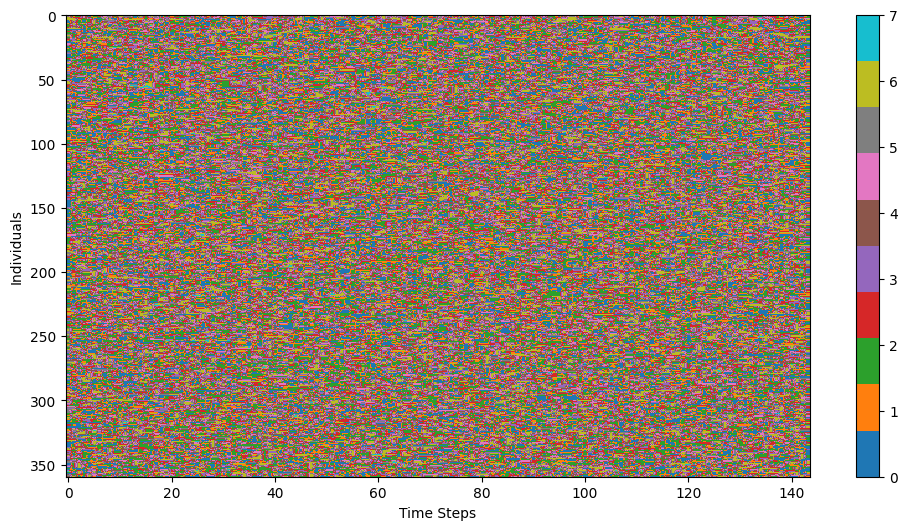

In [90]:
plot_image_grid(discrete_activities.cpu(), title = '')

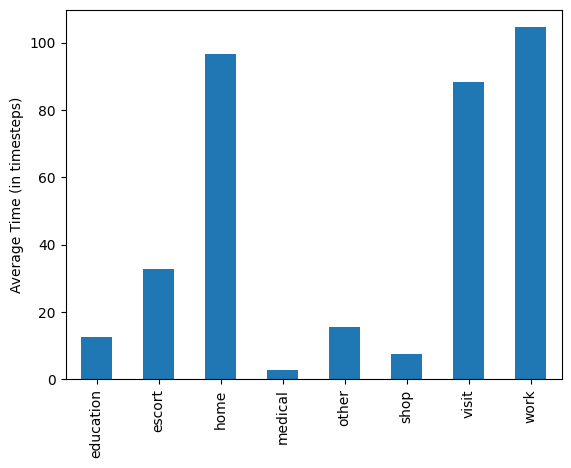

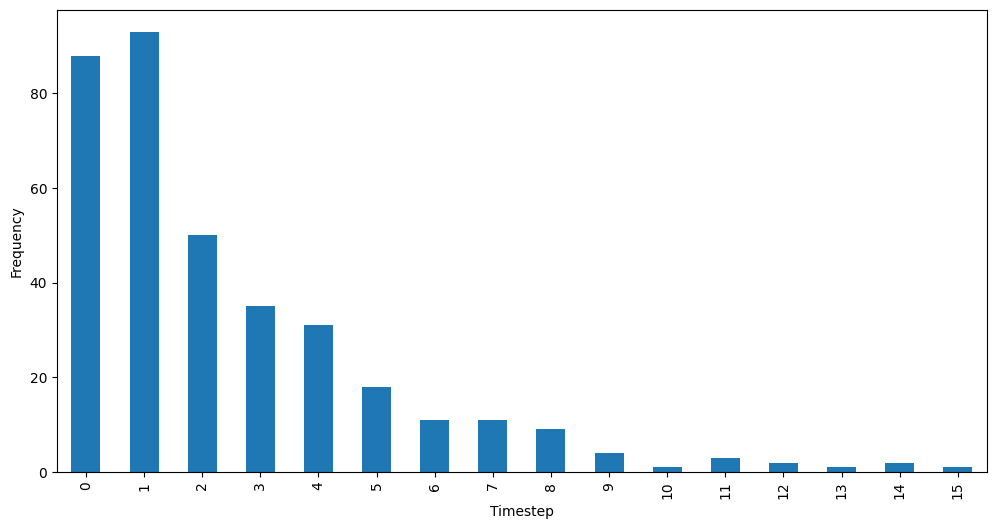

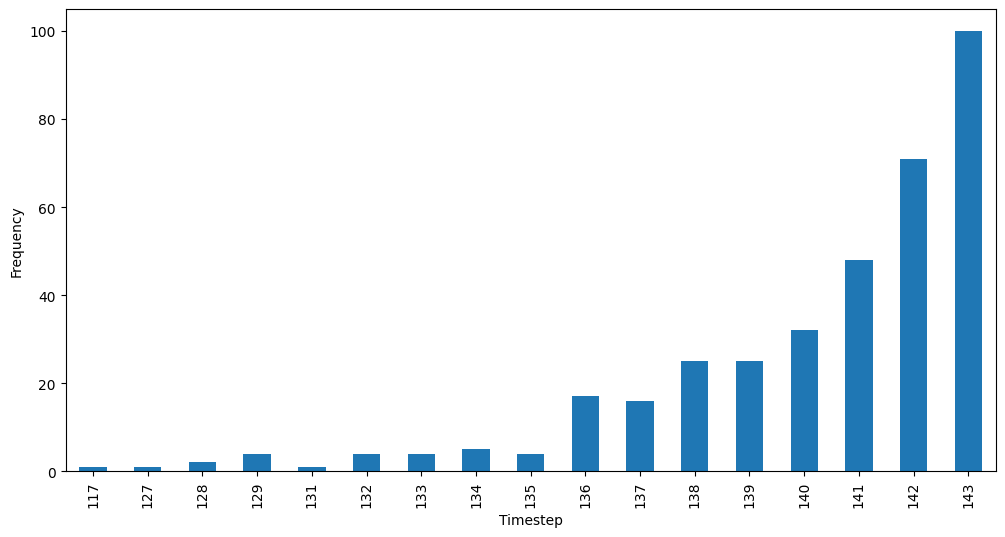

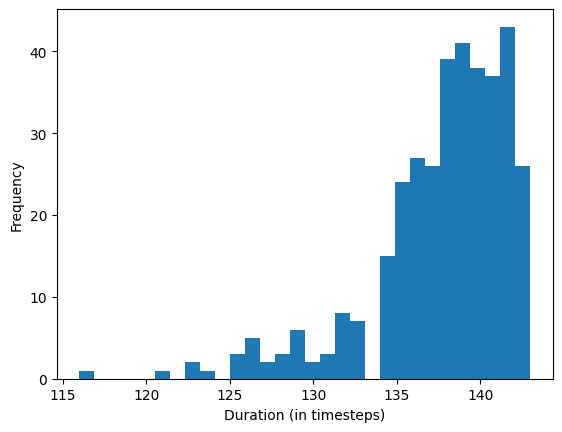

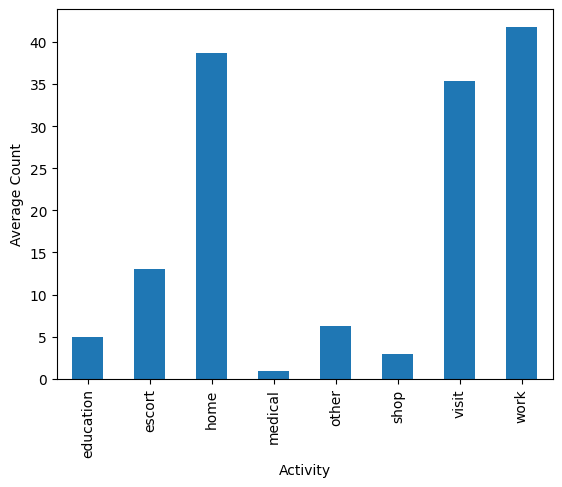

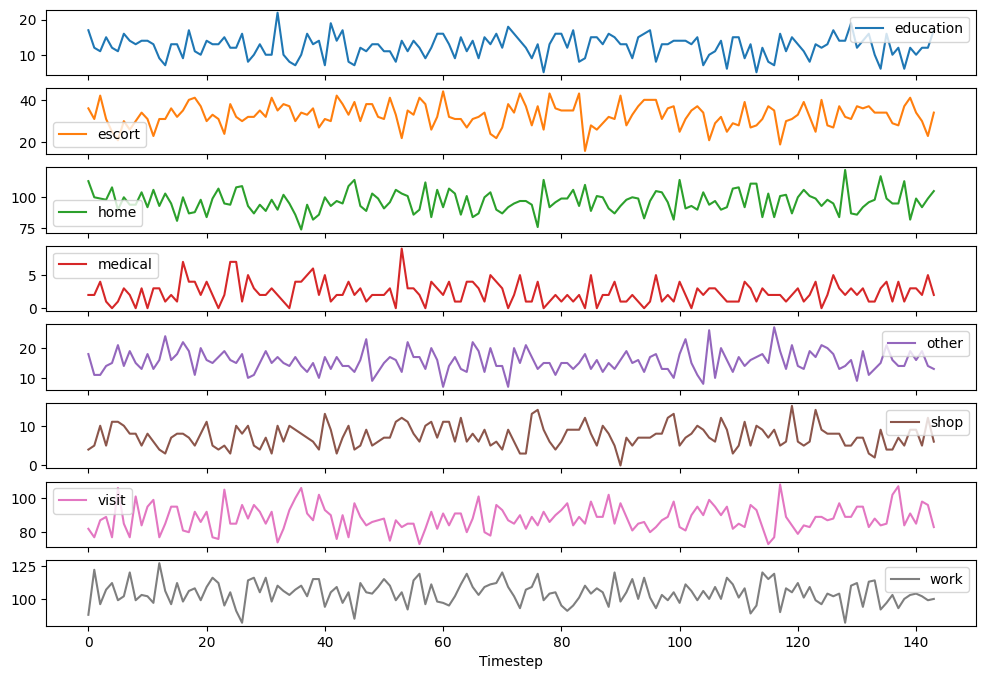

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# Test 1: Calculate average time spent on each activity
average_time_per_activityg = df_decoded.apply(lambda x: x.value_counts()).mean(axis=1)
average_time_per_activityg.plot(kind='bar')
plt.ylabel('Average Time (in timesteps)')
plt.show()

# Test 2 and 3: Activity Start and End Times
# Handling the case where 'work' might not be present in a row
work_start_timesg = df_decoded.apply(lambda row: row.index[row == 'work'].min() if 'work' in row.values else None, axis=1)
work_end_timesg = df_decoded.apply(lambda row: row.index[row == 'work'].max() if 'work' in row.values else None, axis=1)

# Filter out None values if there are any
work_start_timesg.dropna(inplace=True)
work_end_timesg.dropna(inplace=True)

# Plotting start times
if not work_start_timesg.empty:
    work_start_times_counts = work_start_timesg.value_counts().sort_index()
    if not work_start_times_counts.empty:
        work_start_times_counts.plot(kind='bar', figsize=(12, 6))
        plt.xlabel('Timestep')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print("No work start times to plot.")
else:
    print("work_start_times is empty. Check if 'work' activities are present in the dataset.")

# Plotting end times
if not work_end_timesg.empty:
    work_end_timesg.value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
    plt.xlabel('Timestep')
    plt.ylabel('Frequency') 
    plt.show()
else:
    print("work_end_times is empty. Check if 'work' activities are present in the dataset.")

# Calculate durations
work_durationsg = work_end_timesg - work_start_timesg

# Plot the histogram of work durations
work_durationsg.plot(kind='hist', bins=30)
plt.xlabel('Duration (in timesteps)')
plt.ylabel('Frequency')
plt.show()

# Test 5: Activity Count
# Calculate the count of each activity per individual per day
activity_countsg = df_decoded.apply(lambda row: row.value_counts(), axis=1).fillna(0)
activity_countsg.mean().plot(kind='bar')
plt.xlabel('Activity')
plt.ylabel('Average Count')
plt.show()

# Test 6: Peak Hours Analysis
# Create a count of all activities per timestep
activity_frequency_per_timestepg = df_decoded.melt(var_name='Timestep', value_name='Activity').groupby('Timestep')['Activity'].value_counts().unstack(fill_value=0)
activity_frequency_per_timestepg.plot(subplots=True, layout=(-1, 1), figsize=(12, 8), sharex=True)
plt.xlabel('Timestep')
plt.show()


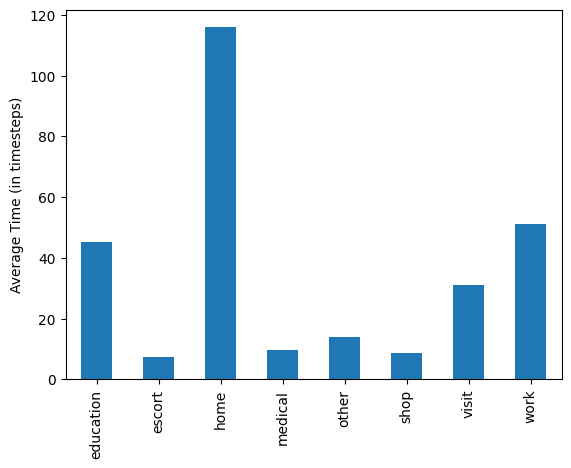

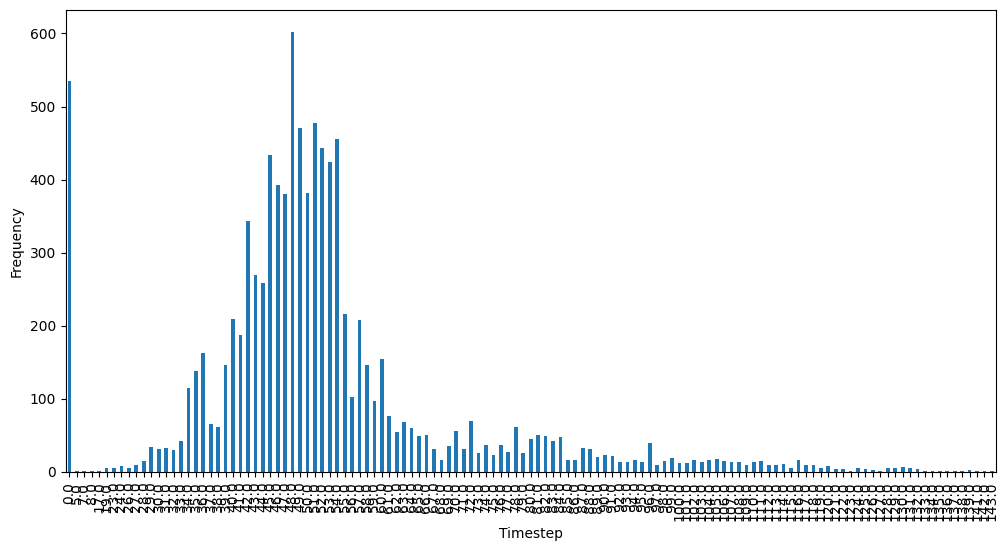

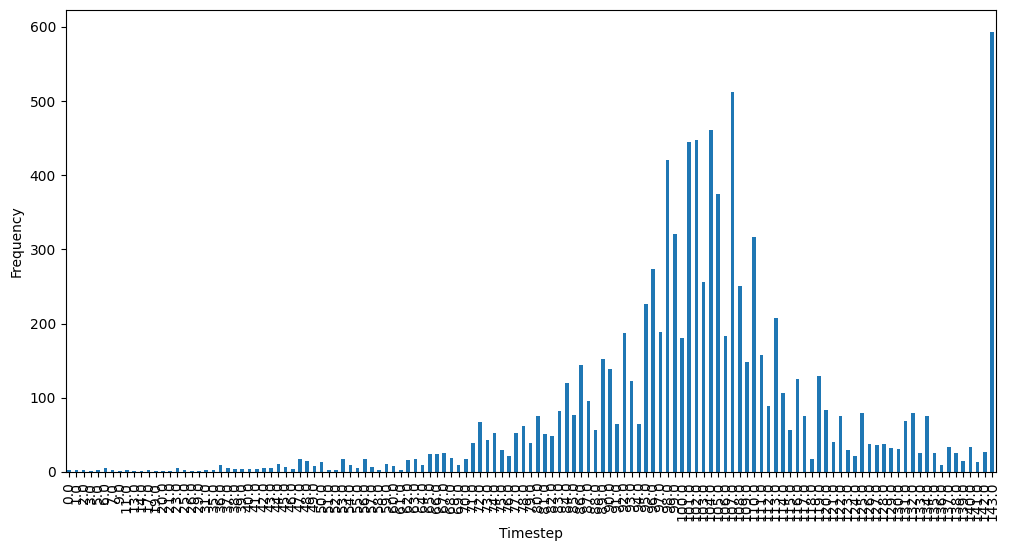

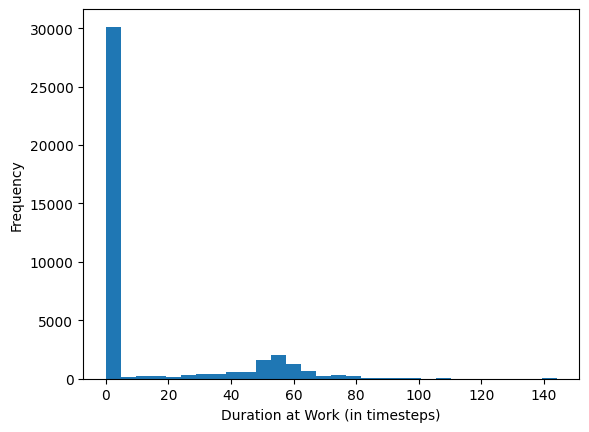

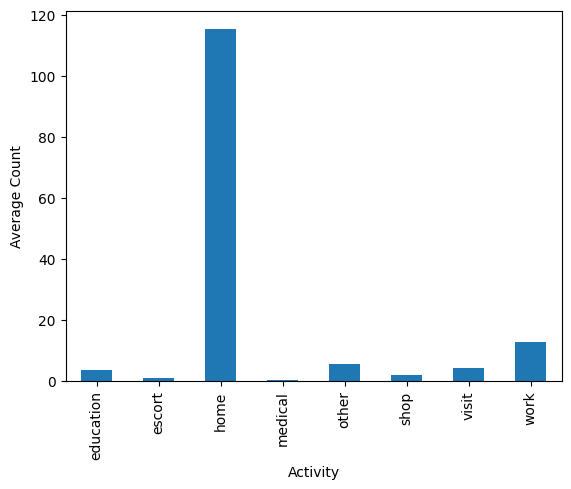

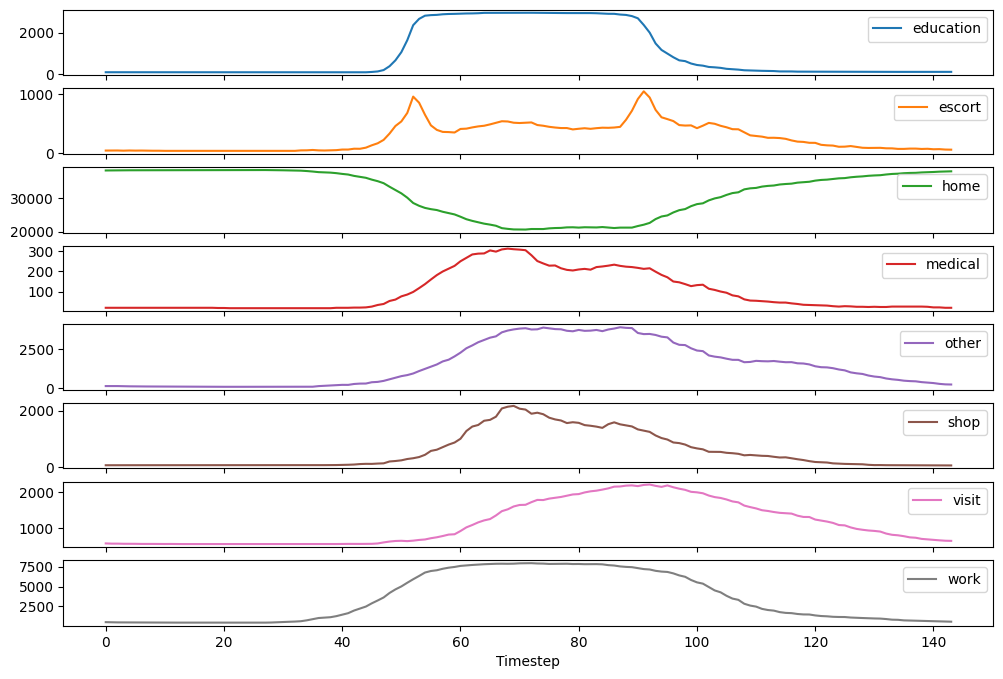

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_original.copy()

# Test 1: Calculate average time spent on each activity per individual
time_per_activity_per_individual = df.apply(lambda x: x.value_counts(), axis=1)
average_time_per_activity = time_per_activity_per_individual.mean(axis=0)
average_time_per_activity.plot(kind='bar')
plt.ylabel('Average Time (in timesteps)')
plt.show()


# Test 2 and 3: Activity Start and End Times
# Handling the case where 'work' might not be present in a row
work_start_times = df.apply(lambda row: row.index[row == 'work'].min() if 'work' in row.values else None, axis=1)
work_end_times = df.apply(lambda row: row.index[row == 'work'].max() if 'work' in row.values else None, axis=1)

# Filter out None values if there are any
work_start_times.dropna(inplace=True)
work_end_times.dropna(inplace=True)

# Plotting start times
if not work_start_times.empty:
    work_start_times_counts = work_start_times.value_counts().sort_index()
    if not work_start_times_counts.empty:
        work_start_times_counts.plot(kind='bar', figsize=(12, 6))
        plt.xlabel('Timestep')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print("No work start times to plot.")
else:
    print("work_start_times is empty. Check if 'work' activities are present in the dataset.")

# Plotting end times
if not work_end_times.empty:
    work_end_times.value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
    plt.xlabel('Timestep')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("work_end_times is empty. Check if 'work' activities are present in the dataset.")

# Test 4: Work Duration Distribution
# Count the occurrence of 'work' for each individual's daily activity sequence
work_durations = df.apply(lambda x: (x == 'work').sum(), axis=1)

# Plot the histogram of work durations
work_durations.plot(kind='hist', bins=30)
plt.xlabel('Duration at Work (in timesteps)')
plt.ylabel('Frequency')
plt.show()

# Test 5: Activity Count
# Calculate the count of each activity per individual per day
activity_counts = df.apply(lambda row: row.value_counts(), axis=1).fillna(0)
activity_counts.mean().plot(kind='bar')
plt.xlabel('Activity')
plt.ylabel('Average Count')
plt.show()

# Test 6: Peak Hours Analysis
# Create a count of all activities per timestep
activity_frequency_per_timestep = df.melt(var_name='Timestep', value_name='Activity').groupby('Timestep')['Activity'].value_counts().unstack(fill_value=0)
activity_frequency_per_timestep.plot(subplots=True, layout=(-1, 1), figsize=(12, 8), sharex=True)
plt.xlabel('Timestep')
plt.show()


In [83]:
prob_real = activity_frequency_per_timestep.div(activity_frequency_per_timestep.sum(axis=1), axis=0)
prob_synthetic = activity_frequency_per_timestepg.div(activity_frequency_per_timestepg.sum(axis=1), axis=0)

# Replace zero probabilities to avoid division by zero in KL calculation
prob_real = prob_real.replace(0, np.finfo(float).eps)
prob_synthetic = prob_synthetic.replace(0, np.finfo(float).eps)

# Calculate KL Divergence for each timestep
kl_divergence = (prob_real * np.log(prob_real / prob_synthetic)).sum(axis=1)

# Sum over all timesteps to get the total KL divergence
total_kl_divergence = kl_divergence.sum()

print(f"Total KL Divergence: {total_kl_divergence}")

Total KL Divergence: 114.99376003492065
